# Gumbo Weather Analysis
The purpose of this notebook is to compare historical temperature data from New Orleans, Louisiana to climate projections and assess the likelihood of sub-50 degree (F) days, optimal weather for Gumbo as identified by my grandfather, occurring during winter in different climatological intervals. We have 4 intervals. Two (between 1960-1990 and 1990-2020) come from historical data. Two intervals (2020-2050 and 2050-2080) use data from climate models running scenarios for [Relative Concentration Pathway 4.5](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway), accessed in the previous notebook.  
<br>
In the first section, we **import, manage and restructure the climate records**. The historical record pieces together records from two weather stations, and those records need to be combined. The individual climate models need to be appraised individually, and then averaged into an ensemble. Both historical records and climate models need to be sliced into 30 year climatological intervals, and averaged/statistically analyzed across them.  
<br>
In the second section, we **compare those climatologies to a threshold to calculate the probability of any day of the year being a sub 50 degree day**. This can be done as simply as counting the number of days with temperatures below 50 degrees, and expressing it as a percentage of the total days in the interval.

## Section One: Create Climatologies
### Import packages

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy import interpolate,signal
import os

### Set paths
These are my local paths, please change these to the destination of the GitHub repo and its subdirectories on your computer.

In [153]:
data_path='/Users/danielbabin/GitHub/Gumbo_Weather/Data/'
table_path='/Users/danielbabin/GitHub/Gumbo_Weather/Tables/'

## Historical Data
We have two data sources here. One is from [Audubon Park](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00012930/detail) and the other from [MSY Airport](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00012916/detail). Data from both weather stations can be accessed through [NOAA's website](https://www.ncei.noaa.gov). Stacking data from two weather stations is ideal because problems with instruments leaves gaps in records from a single station. 

In [154]:
audubon=pd.read_csv(data_path+'audubon.csv')
audubon['datetime']=pd.to_datetime(audubon['DATE'],format='%Y%m%d')
audubon.set_index('datetime',inplace=True)
audubon[audubon['TMAX']==-9999]=np.nan
audubon[audubon['TMIN']==-9999]=np.nan

airport=pd.read_csv(data_path+'airport.csv')
airport['datetime']=pd.to_datetime(airport['DATE'],format='%Y/%m/%d')
airport.set_index('datetime',inplace=True)

In [155]:
for df in [audubon,airport]:
    df['Year']=df.index.year
    df['Month']=df.index.month
    df['Day']=df.index.day

### Stack the stations
Below is a plot of both weather stations over the same time intervals. **Above**: a year, **Below**: two months.

In [156]:
year=2015

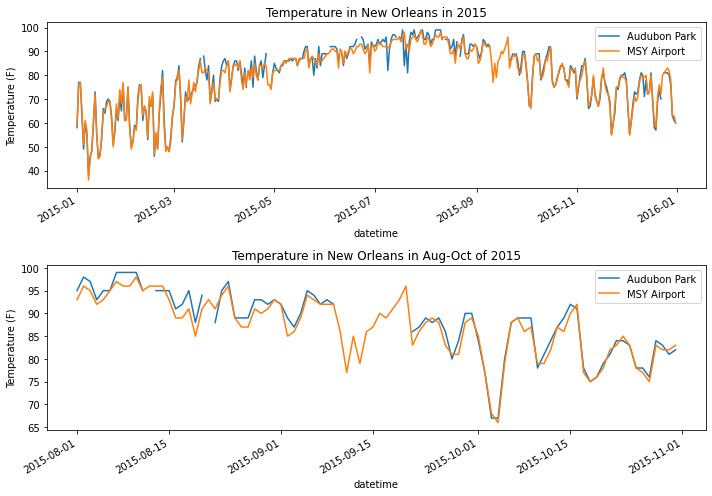

In [157]:
fig,axes=plt.subplots(nrows=2,figsize=(10,7))
ax=axes[0]
(audubon['TMAX'].loc[str(year)+'-01-01':str(year)+'-12-31']-1).plot(ax=ax,label='Audubon Park')
(airport['TMAX'].loc[str(year)+'-01-01':str(year)+'-12-31']).plot(ax=ax,label='MSY Airport')
ax.legend()
ax.set_title('Temperature in New Orleans in '+str(year))
ax.set_ylabel('Temperature (F)')

ax=axes[1]
(audubon['TMAX'].loc[str(year)+'-08-01':str(year)+'-10-31']-1).plot(ax=axes[1],label='Audubon Park')
(airport['TMAX'].loc[str(year)+'-08-01':str(year)+'-10-31']).plot(ax=axes[1],label='MSY Airport')
axes[1].legend()
ax.set_title('Temperature in New Orleans in Aug-Oct of '+str(year))
ax.set_ylabel('Temperature (F)')

plt.tight_layout()

Temperatures at Audubon were found to be 1 degree F warmer than MSY on average. This is because Audubon Park is located in the city center, and heat pools in the urban areas of cities. Therefore, 1 degree F is subtracted from the Audubon record before they are averaged

In [158]:
stack=airport.copy()
stack=stack.drop(['STATION','NAME','DATE'],axis=1)
stack=stack.rename(columns={'TMAX':'AUD_TMAX','TMIN':'AUD_TMIN','TAVG':'AUD_TAVG'})
stack[['AUD_TMAX','AUD_TMIN','AUD_TAVG']]=stack[['AUD_TMAX','AUD_TMIN','AUD_TAVG']]-1
stack[['MSY_TMAX','MSY_TMIN','MSY_TAVG']]=audubon.reindex(stack.index)[['TMAX','TMIN','TOBS']]
stack['TMAX_STACK']=stack[['MSY_TMAX','AUD_TMAX']].mean(axis=1)
stack['TMIN_STACK']=stack[['MSY_TMIN','AUD_TMIN']].mean(axis=1)
stack['TAVG_STACK']=stack[['TMAX_STACK','TMIN_STACK']].mean(axis=1)

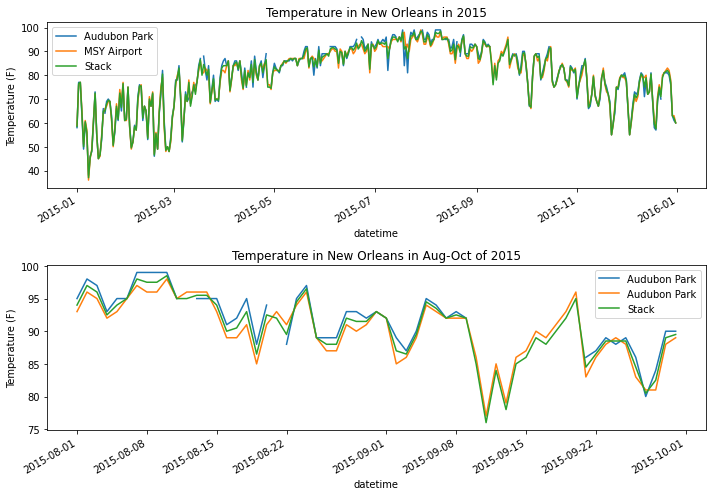

In [159]:
fig,axes=plt.subplots(nrows=2,figsize=(10,7))
(audubon['TMAX'].loc[str(year)+'-01-01':str(year)+'-12-31']-1).plot(ax=axes[0],label='Audubon Park')
airport['TMAX'].loc[str(year)+'-01-01':str(year)+'-12-31'].plot(ax=axes[0],label='MSY Airport')
stack['TMAX_STACK'].loc[str(year)+'-01-01':str(year)+'-12-31'].plot(ax=axes[0],label='Stack')
axes[0].legend()
axes[0].set_title('Temperature in New Orleans in '+str(year))
axes[0].set_ylabel('Temperature (F)')

(audubon['TMAX'].loc[str(year)+'-08-01':str(year)+'-09-30']-1).plot(ax=axes[1],label='Audubon Park')
airport['TMAX'].loc[str(year)+'-08-01':str(year)+'-09-30'].plot(ax=axes[1],label='Audubon Park')
stack['TMAX_STACK'].loc[str(year)+'-08-01':str(year)+'-09-30'].plot(ax=axes[1],label='Stack')
axes[1].legend()
axes[1].set_title('Temperature in New Orleans in Aug-Oct of '+str(year))
axes[1].set_ylabel('Temperature (F)')

plt.tight_layout()

### Pivot index to day of the year
Right now, the data has many thousands of rows, where each row is a day that has temperature values over the course of many years. I would like the table to have only 365 rows, and the years as columns. We also arrange the data to start in August, so winter appears in the middle of the plot.

In [160]:
stack.head()

,AUD_TAVG,AUD_TMAX,AUD_TMIN,Year,Month,Day,MSY_TMAX,MSY_TMIN,MSY_TAVG,TMAX_STACK,TMIN_STACK,TAVG_STACK
datetime,,,,,,,,,,,,
1946-01-01,50.0,NaN,NaN,1946,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1946-01-02,51.0,NaN,NaN,1946,1,2,65.0,36.0,61.0,65.0,36.0,50.5
1946-01-03,58.0,NaN,NaN,1946,1,3,73.0,48.0,67.0,73.0,48.0,60.5
1946-01-04,60.0,NaN,NaN,1946,1,4,72.0,53.0,67.0,72.0,53.0,62.5
1946-01-05,64.0,NaN,NaN,1946,1,5,71.0,57.0,64.0,71.0,57.0,64.0


In [161]:
start_daynum=213

In [162]:
stack['Month-Day']=(stack['Month'].astype(str).str.zfill(2)+'-'+stack['Day'].astype(str).str.zfill(2))    
stack_noleap=stack[stack['Month-Day']!='02-29'].copy().loc['1960':]
cycle=np.arange(365-start_daynum+1,365).tolist()+np.arange(0,365-start_daynum+1).tolist()
cyclecolumn=cycle*(stack.Year.max()-stack.Year.min()+1)
cyclecolumn=cyclecolumn[:len(stack_noleap)]
stack_noleap['#nCycle']=cyclecolumn

In [168]:
historical=stack_noleap.pivot(index=['#nCycle','Month-Day'],
                              columns='Year',values='TMAX_STACK').reset_index(level=0).iloc[:,1:]

### Visualize
Below you can see the shape of the data. Each year stacked on top of the year before it. Older years have bluer colors, more recent years have yellower colors. 

In [169]:
start_year=1960

In [170]:
daterangemin=start_year
daterangemax=2021
nyears=daterangemax-daterangemin

In [171]:
all_colors=sns.color_palette('viridis',nyears)

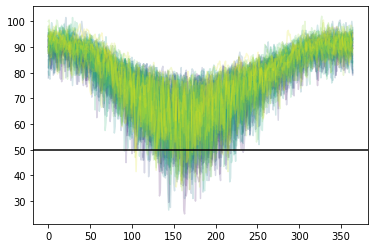

In [172]:
fig,ax=plt.subplots()
for i,year in enumerate(range(daterangemin,daterangemax)):
    historical.reset_index(level=0)[year].plot(ax=ax,color=all_colors[i],alpha=.2)
ax.axhline(50,color='k')

### Calculate Climatology
Weather data is very noisy. Therefore, we take the average over many years. Below, this, called the climatological means, is calculated. Climate is typically appraised over a 30 year interval. We calculate both the mean and std deviation. 

In [173]:
n=30
climatology_std=historical.rolling(n,axis=1,min_periods=n-1).std().iloc[:,n::n]
climatology_mean=historical.rolling(n,axis=1,min_periods=n-1).mean().iloc[:,n::n]

In [174]:
historical_colors=sns.color_palette('viridis',climatology_mean.shape[1])

In [175]:
historical_colors

[(0.190631, 0.407061, 0.556089), (0.20803, 0.718701, 0.472873)]

In [176]:
from matplotlib.patches import Rectangle

In [177]:
years=climatology_mean.columns.tolist()

### Visualize
Heads up, each of the records and standard deviation is filtered with a 30 day moving average to make it easier on the eyes.

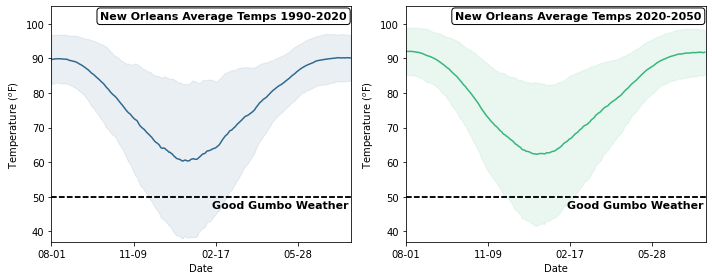

In [178]:
years=[1990,2020]
fig,axes=plt.subplots(ncols=2,figsize=(10,4))
for i,ax in enumerate(axes):
    ser=climatology_mean[years[i]].rolling(30,center=True,min_periods=15).mean()
    std_ser=climatology_std[years[i]].rolling(30,center=True,min_periods=15).mean()
    
    ser.plot(ax=ax,color=historical_colors[i])
    ax.fill_between(x=climatology_mean.index,
                    y1=ser-2*std_ser,
                    y2=ser+2*std_ser,
                    color=historical_colors[i],alpha=.1)
    
    xmax=len(climatology_mean)
    ymax=105
    ymin=37
    ax.axhline(50,color='k',ls='--')
    ax.set_xlim(0,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature ($^o$F)')
    ax.axhline(50,color='k',ls='--')
    
    ax.annotate('Good Gumbo Weather',xy=(xmax-3,49),
                ha='right',va='top',fontweight='bold',fontsize=11)
    
    ax.annotate('New Orleans Average Temps '+str(years[i])+'-'+str(years[i]+30),xy=(xmax-5,ymax-1.4),
            ha='right',va='top',fontsize=11,fontweight='bold',
            bbox=dict(boxstyle='round',fc='w',ec='k'));
plt.tight_layout()

## Climate Projections
This portion of the code uses the data for climate projections drawn down using the Access CMIP6 notebook.

In [179]:
files=os.listdir(data_path)
files.sort()
files=files[1:]
handles=[file[:-4] for file in files]

Here you can select which scenario we use. We advance using the 'ssp245' tag, which represents [Relative Concentration Pathway 4.5](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway), a moderate CO2 emissions scenario.

In [180]:
chosen_tables=['historical','ssp245']

### Import, Reshaping, Convert, Model Stats
The code below functions similar to the code we applied to the historical data. It groups the projections into two different intervals. One between 2020-2050, and another between 2050-2080. For each of these intervals, it reshapes that data Into a table with 365 rows, one for each day of the year, and columns for each year. This operation is slightly more complicated because there are many different simulations for each year, each representing differnt climate models, which will have slightly different physics. 

In [181]:
chosen_projections=['historical','ssp245 20-50','ssp245 50-80']
slice_years={'ssp245 20-50':['2020','2050'],
             'ssp245 50-80':['2050','2080']}

In [496]:
tables={}
projections={}
model_list={}
projs_means={}
projs_stds={}

for tablename in chosen_tables:
    tables[tablename]=pd.read_csv(data_path+tablename+'.csv')
    tables[tablename]['datetime']=pd.to_datetime(tables[tablename]['date'])
    tables[tablename].set_index('datetime',inplace=True)

for handle in chosen_projections:
    if handle=='historical':
        projections[handle]=tables[handle].copy()
        model_list[handle]=projections[handle].columns[4:].to_list()
        nyears=30
    else:
        if handle=='ssp245 20-50':
            projections[handle]=tables[handle[:6]].loc[slice_years[handle][0]:slice_years[handle][1]].copy()
        elif handle=='ssp245 50-80':
            projections[handle]=tables[handle[:6]].loc[slice_years[handle][0]:slice_years[handle][1]].copy()
        model_list[handle]=projections[handle].columns[5:].to_list()
        nyears=31
    
    ### date
    projections[handle]['Year']=projections[handle].index.year
    projections[handle]['Month']=projections[handle].index.month
    projections[handle]['Day']=projections[handle].index.day
    projections[handle]['Month-Day']=(projections[handle]['Month'].astype(str).str.zfill(2)+'-'+
                                      projections[handle]['Day'].astype(str).str.zfill(2))
    
    cycle=np.arange(365-start_daynum+1,365).tolist()+np.arange(0,365-start_daynum+1).tolist()
    projections[handle]['#nCycle']=cycle*nyears
    
    ### reshape
    projections[handle]=projections[handle].pivot(index=['#nCycle','Month-Day'],columns='Year',
                                                  values=model_list[handle])
    
    ###
    projs_means[handle]=pd.DataFrame(index=projections[handle].index)
    projs_stds[handle]=pd.DataFrame(index=projections[handle].index)
    for model in model_list[handle]:
        projs_stds[handle][model]=(projections[handle][model].std(axis=1)*9/5)
        projs_means[handle][model]=(projections[handle][model].mean(axis=1)-273)*9/5+32
        
    projs_stds[handle]=projs_stds[handle].reset_index(level=0).iloc[:,1:]
    projs_means[handle]=projs_means[handle].reset_index(level=0).iloc[:,1:] 
    projections[handle]=projections[handle].reset_index(level=0)

### Anomaly with 1985-2014
It is best to compare each models output temperature for a year in the future to the same model's output for a day in the past, and add that temperature difference to a real, measured historical temperature, rather than take the output of the model directly. This is a common procedure for climate models.  
  
The "historical" simulations for these climate models end at 2015, so we take that climatology (1985-2015) from the models, and compare it to the climatology from that same time interval in the historical data.

In [522]:
historical_v_model_mean_change={}
historical_v_model_std_change={}
for handle in chosen_projections[1:]:
    historical_v_model_mean_change[handle]=pd.DataFrame(index=projs_means[handle].index)
    historical_v_model_std_change[handle]=pd.DataFrame(index=projs_means[handle].index)
        
    for model in model_list[handle]:
        if model in model_list['historical']:
            historical_v_model_mean_change[handle][model]=(projs_means[handle][model]-
                                                           projs_means['historical'][model])
            std_future_anomalies=(((projections[handle][model]-273)*9/5+32)
                                  .subtract(projs_means[handle][model],axis=0).std(axis=1))
            std_historical_anomalies=(((projections['historical'][model]-273)*9/5+32)
                                      .subtract(projs_means['historical'][model],axis=0).std(axis=1))
            
            historical_v_model_std_change[handle][model]=std_future_anomalies/std_historical_anomalies

In [528]:
data1985to2014=historical.iloc[:,25:-7]

In [575]:
test_u=data1985to2014.add(historical_v_model_mean_change['ssp245 20-50']['GFDL-ESM4'],axis=0)
final_proj=((test_u.subtract(test_u.mean(axis=1),axis=0))
            .mul(historical_v_model_std_change['ssp245 20-50']['GFDL-ESM4'],axis=0)
            .add(test_u.mean(axis=1),axis=0))

In [605]:
final_projs={}
for handle in chosen_projections[1:]:
    final_projs[handle]={}
    for model in historical_v_model_mean_change[handle].columns:
        final_projs[handle][model]=pd.DataFrame(index=projs_means[handle].index)
        u_change=data1985to2014.add(historical_v_model_mean_change[handle][model],axis=0)
        final_projs[handle][model]=((u_change.subtract(u_change.mean(axis=1),axis=0))
                                    .mul(historical_v_model_std_change[handle][model],axis=0)
                                    .add(u_change.mean(axis=1),axis=0))
        if handle=='ssp245 20-50':
            final_projs[handle][model].columns=np.arange(2020,2050,1)
        if handle=='ssp245 50-80':
            final_projs[handle][model].columns=np.arange(2050,2080,1)

### Ensemble
Climate models are typically appraised in an ensemble. This means you look at a group of models and calculate a sort of average behavior. It's best to calculate a sort of weighted mean, where the weight for each model comes from how well this model performed in simulating past climate variability. The source for this method is [Brunner et al., 2020](https://esd.copernicus.org/articles/11/995/2020/). This approach actually reduces the projected warming rather than accentuating it.   
![](Images/brunner_2020.jpg) <div style='text-align: right'> </div> 
Source: [Brunner et al., 2020](https://esd.copernicus.org/articles/11/995/2020/) <br><br>
I just pulled down whatever was found on the Google Cloud File Storage System in the last notebook. Some models in Brunner's study are missing from that system. Many of the models with the highest weights (for example, GFDL-ESM4) were present, so I just proceeded with the ones I had. The total of the weights in our study is equal to 0.577, so after doing the weighted average, we multiply the results by 1/0.577 to renormalize the values to sum to 100%.

In [186]:
weights={'ACCESS-CM2':0.0499,'ACCESS-ESM1-5':0.0358,'AWI-CM-1-1-MR':0.0436,'BCC-CSM2-MR':0.0354,
         'CanESM5':0.0013,'EC-Earth3-Veg':0.0092,'EC-Earth3':0.0079,'FGOALS-g3':0.0069,'GFDL-ESM4':0.1287,
         'INM-CM4-8':0.0142,'INM-CM5-0':0.0430,'IPSL-CM6A-LR':0.0224,'MIROC6':0.0378,'MPI-ESM1-2-HR':0.0524,
         'MPI-ESM1-2-LR':0.0401,'MRI-ESM2-0':0.0189,'NESM3':0.0072,'NorESM2-MM':0.0223}

In [743]:
weighted[handle].keys()

dict_keys(['GFDL-ESM4', 'BCC-CSM2-MR', 'CanESM5', 'INM-CM4-8', 'INM-CM5-0', 'FGOALS-g3', 'NorESM2-MM'])

In [756]:
weighted={}
ensemble={}
for handle in chosen_projections[1:]:
    weighted[handle]={}
    ensemble[handle]=pd.DataFrame(index=projs_means[handle].index)
    
    models_sum=[]
    for model in final_projs[handle].keys():
        if model in weights.keys():
            weighted[handle][model]=pd.DataFrame(index=projs_means[handle].index)
            
            models_sum.append(weights[model])
            factor=1/sum(models_sum)
            weighted[handle][model]=final_projs[handle][model].mul(weights[model])
    
    for year in weighted[handle]['GFDL-ESM4'].columns:
        ensemble[handle][year]=pd.concat([weighted[handle][model][year] 
                                          for model in weighted[handle].keys()],axis=1).sum(axis=1)*factor

In [765]:
ensemble={}
for handle in chosen_projections[1:]:
    weighted[handle]={}
    ensemble[handle]=pd.DataFrame(index=projs_means[handle].index)
    
    for year in final_projs[handle]['GFDL-ESM4'].columns:
        ensemble[handle][year]=pd.concat([final_projs[handle][model][year] 
                                          for model in final_projs[handle].keys()],axis=1).mean(axis=1)

In [781]:
ensemble_means=pd.DataFrame(index=projs_means[handle].index)
ensemble_means[2050]=ensemble['ssp245 20-50'].mean(axis=1)
ensemble_means[2080]=ensemble['ssp245 50-80'].mean(axis=1)

ensemble_stds=pd.DataFrame(index=projs_means[handle].index)
ensemble_stds[2050]=ensemble['ssp245 20-50'].std(axis=1)
ensemble_stds[2080]=ensemble['ssp245 50-80'].std(axis=1)

### Export Temperature Data

In [783]:
temperature_data=pd.DataFrame(index=climatology_mean.index)
for year in [1990,2020]:
    dfdata=climatology_mean[year]
    text=str(year-30)+'-'+str(year)
    temperature_data[text+' Temperature (F)']=dfdata
    temperature_data[text+' Smooth Temperature (F)']=dfdata.rolling(30,center=True,min_periods=15).mean()
    dfstd=climatology_std[year]
    temperature_data[text+' 1 Std Dev (F)']=dfstd
    temperature_data[text+' Smooth 1 Std Dev (F)']=dfstd.rolling(30,center=True,min_periods=15).mean()

for year in [2050,2080]:
    dfdata=ensemble_means[year]
    text=str(year-30)+'-'+str(year)
    temperature_data[text+' Temperature (F)']=dfdata
    temperature_data[text+' Smooth Temperature (F)']=dfdata.rolling(30,center=True,min_periods=15).mean()
    dfstd=ensemble_stds[year]
    temperature_data[text+' 1 Std Dev (F)']=dfstd
    temperature_data[text+' Smooth 1 Std Dev (F)']=dfstd.rolling(30,center=True,min_periods=15).mean()

In [784]:
temperature_data.to_csv(table_path+'NewOrleansTemperatures.csv')

### Visualize
Heads up, each of the records and standard deviation is filtered with a 30 day moving average to make it easier on the eyes.

In [785]:
projection_colors=sns.color_palette('plasma',2)

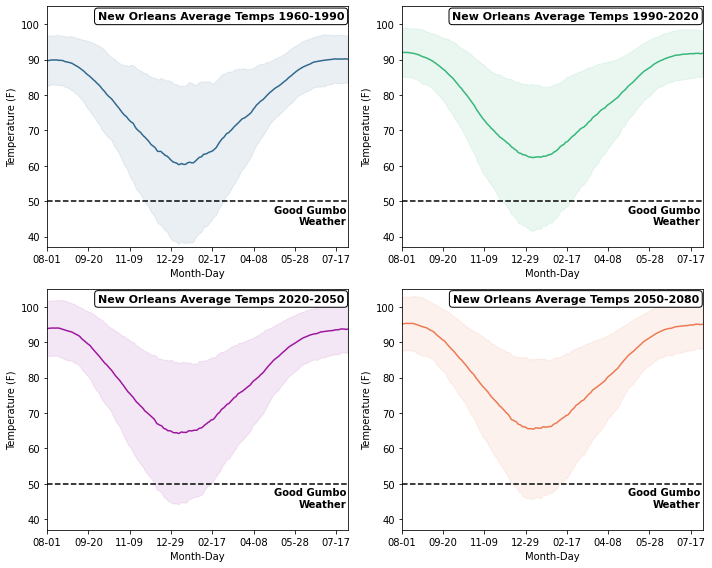

In [786]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(10,8))
plt.subplots_adjust(left=.09,right=.98,top=.98)

ax=axes[0,0]
ser=temperature_data['1960-1990 Smooth Temperature (F)']
ser_std=temperature_data['1960-1990 Smooth 1 Std Dev (F)']
ser.plot(ax=ax,color=historical_colors[0])
ax.fill_between(x=climatology_mean.index,
                y1=ser-2*ser_std,
                y2=ser+2*ser_std,
                color=historical_colors[0],alpha=.1)

ax=axes[0,1]
ser=temperature_data['1990-2020 Smooth Temperature (F)']
ser_std=temperature_data['1990-2020 Smooth 1 Std Dev (F)']
ser.plot(ax=ax,color=historical_colors[1])
ax.fill_between(x=climatology_mean.index,
                y1=ser-2*ser_std,
                y2=ser+2*ser_std,
                color=historical_colors[1],alpha=.1)

ax=axes[1,0]
ser=temperature_data['2020-2050 Smooth Temperature (F)']
ser_std=temperature_data['2020-2050 Smooth 1 Std Dev (F)']
ser.plot(ax=ax,color=projection_colors[0])
ax.fill_between(x=climatology_mean.index,
                y1=ser-2*ser_std,
                y2=ser+2*ser_std,
                color=projection_colors[0],alpha=.1)

ax=axes[1,1]
year=2020
ser=temperature_data['2050-2080 Smooth Temperature (F)']
ser_std=temperature_data['2050-2080 Smooth 1 Std Dev (F)']
ser.plot(ax=ax,color=projection_colors[1])
ax.fill_between(x=climatology_mean.index,
                y1=ser-2*ser_std,
                y2=ser+2*ser_std,
                color=projection_colors[1],alpha=.1)

### y stuff
ymax=105
ymin=37
xmax=len(climatology_mean)
yearlist=['1960-1990','1990-2020','2020-2050','2050-2080']
i=0
for ax in axes:
    for subax in ax:
        subax.set_ylim(ymin,ymax)
        subax.set_xlim(0,xmax)
        subax.axhline(50,color='k',ls='--')
        subax.annotate('Good Gumbo\nWeather',xy=(len(climatology_mean)-3,49),
                    ha='right',va='top',fontweight='bold',fontsize=10)
        subax.set_ylabel('Temperature (F)')
        subax.annotate('New Orleans Average Temps '+yearlist[i],xy=(xmax-5,ymax-1.4),
            ha='right',va='top',fontsize=11,fontweight='bold',
            bbox=dict(boxstyle='round',fc='w',ec='k'));
        i+=1
        
plt.tight_layout()

## Section Two: Gumbo Weather Probability
Go to the top section if you want to read an overview of what's happening here.

In [1381]:
probabilities=pd.DataFrame(index=historical.index)
probabilities['1960-1989 Probability (<50F)']=(historical.iloc[:,0:30]<50).astype(int).sum(axis=1)/30*100
probabilities['1990-2019 Probability (<50F)']=(historical.iloc[:,30:60]<50).astype(int).sum(axis=1)/30*100
probabilities['2020-2049 Probability (<50F)']=(ensemble['ssp245 20-50']<50).astype(int).sum(axis=1)/30*100
probabilities['2050-2079 Probability (<50F)']=(ensemble['ssp245 50-80']<50).astype(int).sum(axis=1)/30*100

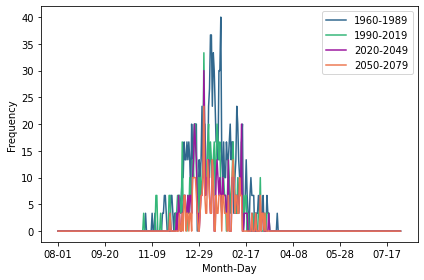

In [1382]:
fig,ax=plt.subplots()
probabilities['1960-1989 Probability (<50F)'].plot(ax=ax,label='1960-1989',color=historical_colors[0])
probabilities['1990-2019 Probability (<50F)'].plot(ax=ax,label='1990-2019',color=historical_colors[1])
probabilities['2020-2049 Probability (<50F)'].plot(ax=ax,label='2020-2049',color=projection_colors[0])
probabilities['2050-2079 Probability (<50F)'].plot(ax=ax,label='2050-2079',color=projection_colors[1])
ax.legend()
ax.set_ylabel('Frequency')
plt.tight_layout()

In [1383]:
smooth_probabilities=pd.DataFrame(index=probabilities.index)

In [1436]:
for col in probabilities.columns:
    smooth_probabilities[col]=probabilities[col].rolling(5,center=True).mean()
    for i in range(30):
        smooth_probabilities[col]=smooth_probabilities[col].rolling(5,center=True).mean()
smooth_probabilities=smooth_probabilities.where(smooth_probabilities>.3,np.nan)

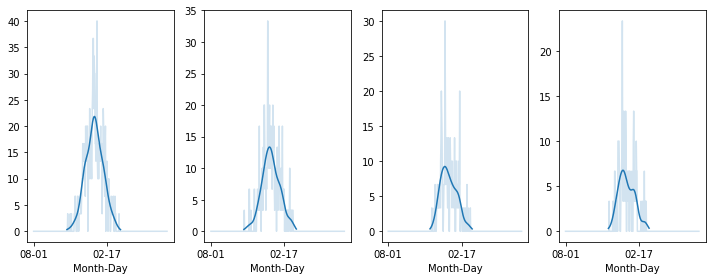

In [1437]:
fig,ax=plt.subplots(ncols=4,figsize=(10,4))
for i,col in enumerate(smooth_probabilities.columns):
    probabilities[col].plot(ax=ax[i],alpha=.2)    
    smooth_probabilities[col].plot(ax=ax[i],color='tab:blue')
plt.tight_layout()

In [1438]:
(smooth_probabilities>0).sum()

1960-1989 Probability (<50F)    147
1990-2019 Probability (<50F)    144
2020-2049 Probability (<50F)    116
2050-2079 Probability (<50F)    112
dtype: int64

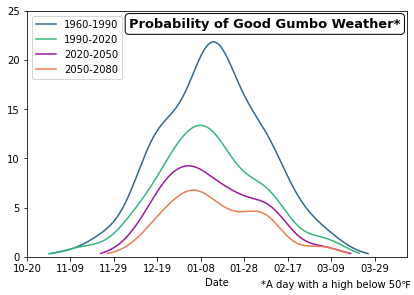

In [1439]:
fig,ax=plt.subplots(facecolor='w')
plt.subplots_adjust(left=.1,right=.98,top=.98)
smooth_probabilities['1960-1989 Probability (<50F)'].plot(color=historical_colors[0],ax=ax,label='1960-1990')
smooth_probabilities['1990-2019 Probability (<50F)'].plot(color=historical_colors[1],ax=ax,label='1990-2020')
smooth_probabilities['2020-2049 Probability (<50F)'].plot(color=projection_colors[0],ax=ax,
                                              label='2020-2050')
smooth_probabilities['2050-2079 Probability (<50F)'].plot(color=projection_colors[1],ax=ax,
                                              label='2050-2080')

ymax=25
ymin=0
xmin=80
xmax=255
ax.set_xlabel('Date')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)

ax.legend(loc='upper left')

ax.annotate('*A day with a high below 50℉',xy=(.95,.02),
            xycoords='figure fraction',ha='right',va='bottom');

ax.annotate('Probability of Good Gumbo Weather*',xy=(xmax-3,ymax-.7),
                    ha='right',va='top',fontsize=13,fontweight='bold',
                    bbox=dict(boxstyle='round',fc='w',ec='k'));

## Export

In [1440]:
(probabilities['1960-1989 Probability (<50F)']>.3).astype(int).sum()

105

In [1441]:
smooth_probabilities.to_csv(table_path+'GumboWeatherProbabilities.csv')

## 80 Degree December Day

In [1442]:
Decembers1960_1989=historical.iloc[122:153,0:30]

In [1443]:
Decembers2050_2079=(ensemble['ssp245 50-80']).iloc[122:153]

### Visualize

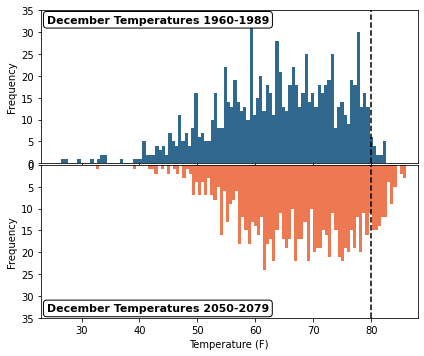

In [1444]:
fig,axes=plt.subplots(nrows=2,sharex=True,figsize=(6,5))

ymin=0
ymax=35
xmin=23
xmax=88

ax=axes[0]
Decembers1960_1989.unstack().plot.hist(ax=ax,bins=100,label='1960-1989',color=historical_colors[0])
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.annotate('December Temperatures 1960-1989',xy=(xmin+1,ymax-1),
                    ha='left',va='top',fontsize=11,fontweight='bold',
                    bbox=dict(boxstyle='round',fc='w',ec='k'));

ax=axes[1]
Decembers2050_2079.unstack().plot.hist(ax=ax,bins=100,label='2050-2079',color=projection_colors[1])
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.invert_yaxis()

for ax in axes:
    ax.axvline(80,color='k',ls='--')
    
ax.set_xlabel('Temperature (F)')
ax.annotate('December Temperatures 2050-2079',xy=(xmin+1,ymax-1),
                    ha='left',va='bottom',fontsize=11,fontweight='bold',
                    bbox=dict(boxstyle='round',fc='w',ec='k'));


plt.tight_layout()
plt.subplots_adjust(hspace=.01)

### Calculate Probability

In [1445]:
(Decembers1960_1989>80).astype(int).sum().sum()/30/31*100

1.3978494623655915

In [1446]:
(Decembers2050_2079>80).astype(int).sum().sum()/30/31*100

9.892473118279572